# Agricultural Price Relative Value

- Historical corn data from Macrotrends https://www.macrotrends.net/2532/corn-prices-historical-chart-data
- historical soybean data from macrotrends https://www.macrotrends.net/2531/soybean-prices-historical-chart-data
- historical wheat data from macrotrends https://www.macrotrends.net/2534/wheat-prices-historical-chart-data

## Commodity Price Data

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import quandl
# Use the following line if you have a quandl api key
#quandl.ApiConfig.api_key = "YOUR_KEY_HERE"

In [9]:
today = dt.datetime.today().strftime('%m/%d/%Y')

# China Corn

We will download DCE dataset from quandl and calculate a rolling active futures index to gauge the price of corn in china

In [10]:
dce_months = {'F':'jan','H':'mar','K':'may', 'N':'jul','U':'sept', 'X':'nov'}
dce_months_num = {'jan':'01','mar':'03','may':'05', 'jul':'07','sept':'09', 'nov':'11'}

In [11]:
dce_corn = pd.DataFrame()

for year in range(2005,2021):
    ag_months = ['F','H','K', 'N','U', 'X']
    
    for mon in ag_months:
        quandl_code = 'C'+mon+str(year)
        add_future = quandl_series = quandl.get('DCE/'+quandl_code)
        add_future['exp_month'] = dce_months[mon]
        add_future['exp_year'] = year
        dce_corn = dce_corn.append(add_future)

In [12]:
dce_corn['month_num'] = dce_corn['exp_month'].apply(lambda x: dce_months_num[x])
dce_corn['exp_day'] = '20'

dce_corn['date_string'] = dce_corn['exp_year'].astype(str)+dce_corn['month_num'].astype(str)+dce_corn['exp_day'].astype(str)
dce_corn['exp_date'] = pd.to_datetime(dce_corn['date_string'])
dce_corn['trade_date'] = dce_corn['exp_date']-dce_corn.index

In [13]:
china_prices = dce_corn[['Close', 'trade_date', 'month_num']]

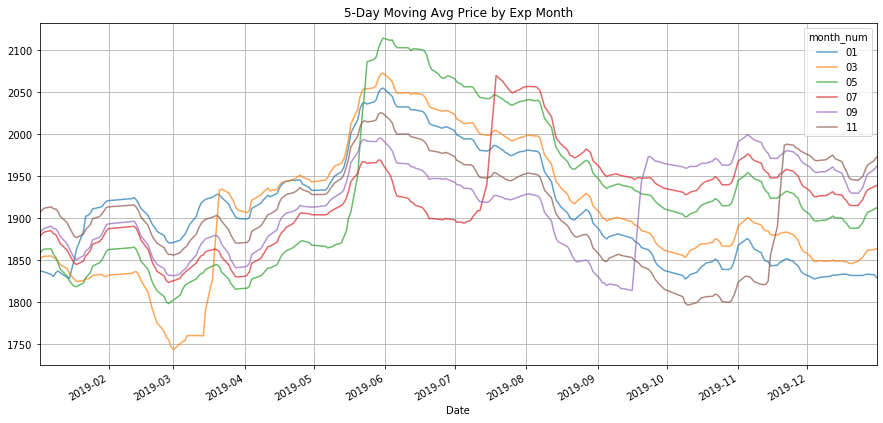

In [132]:
china_exp_by_month = china_prices[['Close','month_num']].pivot(columns='month_num', values='Close')
china_exp_by_month = china_exp_by_month.rolling(5).mean()
china_exp_by_month['2018-12-31':'2019-12-31'].plot(figsize=(15,7),
                                                   grid=True,
                                                   title='5-Day Moving Avg Price by Exp Month',
                                                   alpha=0.7);

In [15]:
china_active = china_prices[['Close','trade_date']].reset_index().sort_values('trade_date').groupby('Date').first()

In [16]:
# Per 60-kilo bag, term prices converted into cash prices by discounting the CDI tax
brazil_corn = quandl.get('CEPEA/CORN', start_date='2004-11-30')
brazil_corn.columns = ['brazil_price','daily_pct','monthly_pct']
brazil_corn = brazil_corn.drop(['daily_pct','monthly_pct'], axis=1)

In [95]:
corn_bushel_to_tonne = 39.3680
soybean_bushel_to_tonne = 36.7440
wheat_bushel_to_tonne = 36.7440

In [104]:
domestic_corn = pd.read_csv('corn_hist.csv',
                            skiprows=16,
                            index_col='Date',
                            names=['Date','usa_corn'])

domestic_corn = domestic_corn.dropna()
domestic_corn.index = pd.to_datetime(domestic_corn.index)

domestic_corn['usa_corn_1T'] = domestic_corn*corn_bushel_to_tonne

domestic_soybean = pd.read_csv('soybean_hist.csv',
                            skiprows=16,
                            index_col='Date',
                            names=['Date','usa_soybean'])

domestic_soybean = domestic_soybean.dropna()
domestic_soybean.index = pd.to_datetime(domestic_soybean.index)

domestic_soybean['soybean_1T'] = domestic_soybean*soybean_bushel_to_tonne

domestic_wheat = pd.read_csv('wheat_hist.csv',
                            skiprows=16,
                            index_col='Date',
                            names=['Date','usa_wheat'])

domestic_wheat = domestic_wheat.dropna()
domestic_wheat.index = pd.to_datetime(domestic_wheat.index)

domestic_wheat['wheat_1T'] = domestic_wheat*wheat_bushel_to_tonne

domestic = domestic_corn.join([domestic_soybean,domestic_wheat]).dropna()

In [116]:
yuan_fx = quandl.get('FED/RXI_N_B_CH', start_date="2004-11-30")
yuan_fx.columns=['yuan_fx']

bzl_corn_conversion = 15.119740787163947

intl_corn = brazil_corn.join([china_active['Close'],yuan_fx, domestic])
intl_corn = intl_corn.rename(columns={'Close':'corn_china'})
intl_corn = intl_corn.ffill()
intl_corn['brazil_corn_1T'] = intl_corn['brazil_price']*bzl_corn_conversion
intl_corn['china_corn_1T'] = (intl_corn['corn_china']/intl_corn['yuan_fx'])

ag_prices = intl_corn[['brazil_corn_1T','china_corn_1T','usa_corn_1T', 'soybean_1T', 'wheat_1T']]

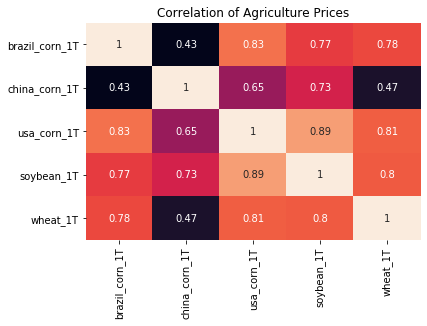

In [131]:
ax = plt.axes()
sns.heatmap(ag_prices.corr(), annot=True, cbar=False, ax=ax)
ax.set_title('Correlation of Agriculture Prices')
plt.show()

In [120]:
corn_differences = ag_prices.subtract(ag_prices['usa_corn_1T'], axis=0).drop('usa_corn_1T',axis=1)

In [124]:
corn_df = corn_differences[[col for col in corn_differences.columns]]
corn_df['variable'] = 'price difference'

In [125]:
zscore_periods = [63, 126, 251, 501]

In [126]:
for period in zscore_periods:
    corn_zscore_add = corn_differences.rolling(period).apply(lambda x: (x[-1]-x.mean())/x.std(), raw=False)
    corn_zscore_add = corn_zscore_add.dropna()
    corn_zscore_add['variable'] = str(period)+' Day Z-Score'
    corn_df = corn_df.append(corn_zscore_add)

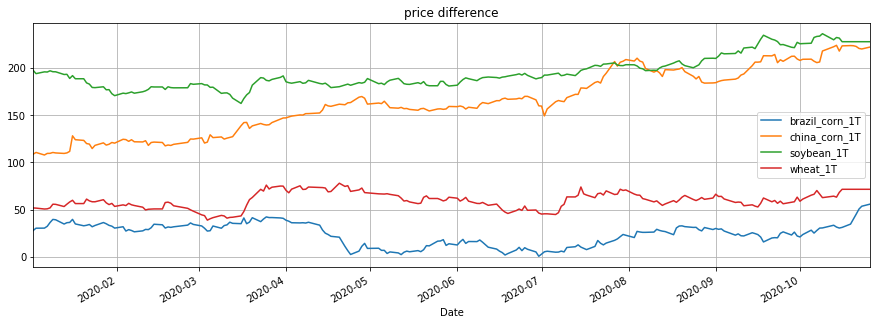

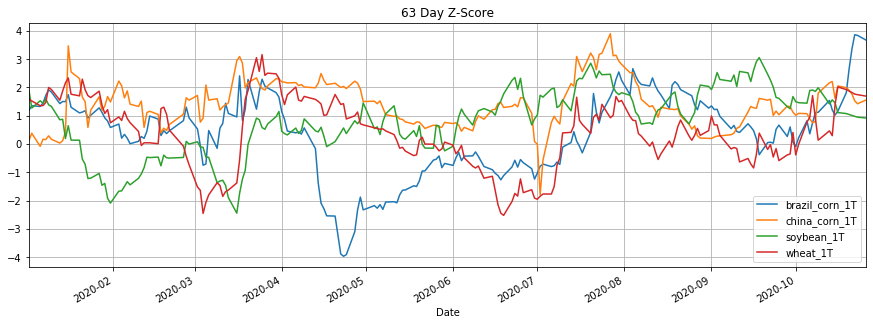

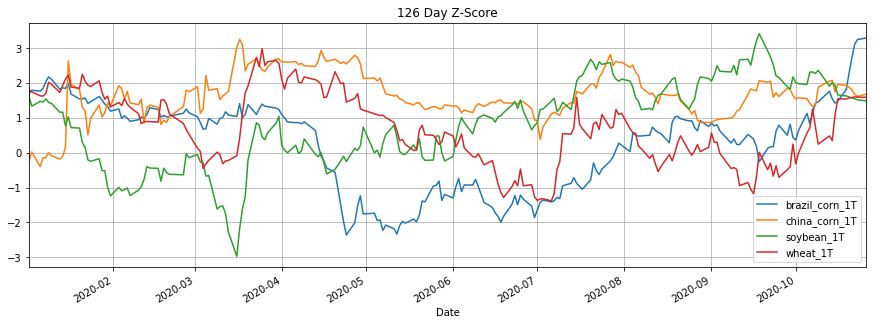

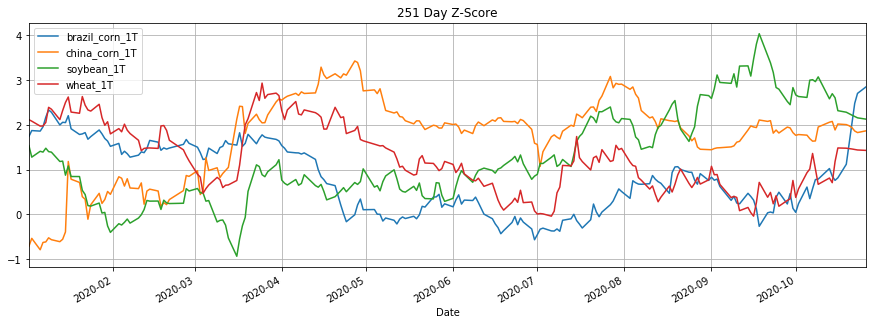

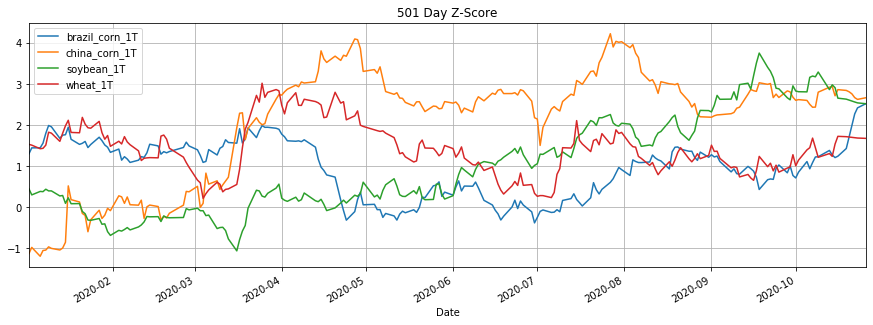

In [130]:
for variable in corn_df['variable'].unique():
    plot_df = corn_df.loc[corn_df['variable'] == variable,[col for col in corn_df.columns if col is not 'variable']]
    plot_df['2019-12-31':].plot(title=variable, figsize=(15,5), grid=True);